In [78]:
#%%writefile wavesolver.py
import numpy as np
from scipy import weave
from scipy.weave import converters

class WaveSolver(object):
    """
    WaveSolver       Class calculates the wave equation in an inhomogeneous medium
    nx:              size of square calculation grid
    wavelength:      wavelength of the excited wave
    CFL:             CFL parameter dt*c/dx should be smaller than 1/sqrt(2)
    c1:              wave speed of the background medium
    c2:              wave speed of the scattering medium
    rho1:            density of the background mdeiums
    rho2:            density of the scattering medium
    sim_duration:    duration of simulation
    src_duration:    duration of the source signal
    plotcallback:    callback function for plotting/saving the result
                     the callback receives two parameters self.u and time
    output:          steps when the "plotcallback" function is called
                     negative: all time steps are send to callback
                     positive number (int or float): every nth timestep is called
                     int list or int numpy.array: list of timesteps where output done
    obstacle:        list of indexes of the grid which are scatterers,
                     i.e. (rho2,c2), default is doubleslit generator
    BC:              Boundary conditions
                     dictionary with 'N','S','W','E' elements having either
                     'open':       outgoing wave b.c.
                     'reflective': hard reflective b.c.
                     
    """
    def __init__(self, nx=128, wavelength=.3, CFL=0.1, c1=1., c2=5., rho1=1., rho2=5.,\
                 sim_duration=2., src_duration=50., output=10, plotcallback=None,\
                 obstacle=None,BC={'W':'open','E':'open','N':'reflective','S':'reflective'}):
        self.__nx=nx
        self.__ny=nx
        self.__size=2.
        self.__dx=self.__size/(self.__nx-1)
        self.__c1=c1
        self.__c2=c2
        self.__rho1=rho1
        self.__rho2=rho2
        self.__sim_duration=sim_duration
        self.__src_duration=src_duration
        self.CFL=CFL
        self.wavelength=wavelength
        self.__emissionlength=(100./100.)*self.__nx #in percent
        self.__startx=int(self.__nx/2.-self.__emissionlength/2.)
        self.__endx=int(self.__nx/2.+self.__emissionlength/2.)
        self.__u  = np.zeros((self.__nx,self.__ny)) #amplitude at t
        self.__un = np.zeros((self.__nx,self.__ny)) #amplitude at t-dt
        self.__unn= np.zeros((self.__nx,self.__ny)) #amplitude at t-2*dt
        self.__sourcepos=0
        self.output=output 
        self.__rho = np.ones((self.__nx,self.__ny))*self.__rho1
        self.__cc = np.ones((self.__nx,self.__ny))*self.__c1*self.__c1
        if plotcallback is not None:
            self.__plotcallback=plotcallback
        else:
            self.__plotcallback=self.simplecallback
        self.__cconst=self.__dt*self.__dt/self.__dx/self.__dx
        self.__BC=BC
        self.__absorber_y=[]
        self.__timestepper=self.__inhomogeneous
        #if obstacle positions were given
        if obstacle is not None: 
            self.__cc[obstacle]=self.__c2*self.__c2
            self.__rho[obstacle]=self.__rho2
            self.__timestepper=self.__inhomogeneous
        else:
            self.__timestepper=self.__homogeneous
    
    
    def simplecallback(self,u,t):
        """Prints the current time"""
        print "time {0:.2}".format(t)

    def singleslit(self, ow=0.1,pos=0.3):
        """
        Single slit experiment, where slit is oriented along y-axis,
        and the wave is coming from the left. The homogeneous wave
        equation is solved.
        ow:  width of the slit
        pos: x-position in real coordinates [0;size]
        """
        yy=np.linspace(0.,self.__size,self.__ny)
        self.__absorber_y=np.where((yy>self.__size/2.+ow/2.)|\
                          (yy<self.__size/2.-ow/2.))
        self.__absorber_x=int(pos*self.__nx/self.__size)
        self.__timestepper=self.__homogeneous        
        
    def doubleslit(self, ow=0.1, dw=1.,pos=0.3):
        """
        Double slit experiment, where the slits are oriented along y-axis,
        and the wave is coming from the left. The homogeneous wave
        equation is solved.
        ow:  width of the slits
        dw: distance between the slits' centers 
        pos: x-position between [0;size]
        """
        yy=np.linspace(0.,self.__size,self.__ny)
        self.__absorber_y=np.where((yy>self.__size/2.+dw/2.+ow/2.)|\
                          (yy<self.__size/2.-dw/2.-ow/2.)|\
                          (yy>self.__size/2.-dw/2.+ow/2.) & (yy<1.+dw/2.-ow/2.))
        self.__absorber_x=int(pos*self.__nx/self.__size)
        self.__timestepper=self.__homogeneous

    @property
    def u(self):
        """Wave on the grid"""
        return self.__u
    
    @property
    def CFL(self):
        """CFL parameter (see class decription)"""
        return self.__CFL
    
    @property
    def dt(self):
        """Length of each timestep"""
        return self.__dt
    
    @property
    def nu(self):
        """Frequency"""
        return self.__nu
    
    @property
    def omega(self):
        """Angular frequency"""
        return 2.*self.__nu*np.pi
    
    @property
    def nt(self):
        """Number of timesteps"""
        return int(self.__sim_duration/self.__dt)
    
    @property
    def wavelength(self):
        """Wavelength"""
        return self.__wavelength
    
    
    @property
    def output(self):
        """List of output timesteps using the plotcallback function"""
        return self.__output
    
    @output.setter
    def output(self, output):
        if (type(output) is np.ndarray) or (type(output) is list):
            self.__output=output
        elif (type(output) is float) or (type(output) is int):
            output=int(output)
            if output>0:
                self.__output=map(int,range(0,int(self.__sim_duration/self.__dt),output))
            elif output<0:
                self.__output=map(int,range(0,int(self.__sim_duration/self.__dt),1))
            else:
                self.__output=[-1]
        else:
            self.__output=[-1]
            
    @CFL.setter
    def CFL(self, CFL):
        self.__CFL = CFL  #CFL number < 1/sqrt(2)
        self.__dt = CFL*self.__dx/(max(self.__c1,self.__c2)) 
        self.__nt=int(self.__sim_duration/self.__dt)
    
    @wavelength.setter
    def wavelength(self, wavelength):
        self.__wavelength = wavelength
        self.__nu=self.__c1/self.__wavelength
          
    def __inhomogeneous(self):
        u=self.__u
        un=self.__un
        unn=self.__unn
        rho=self.__rho
        cc=self.__cc
        cconst=self.__cconst
        nx=self.__nx
        ny=self.__ny
        code = """
            for (int i=1; i<nx-1; ++i) {
                for (int j=1; j<ny-1; ++j) {
                    u(i,j) = 2.*un(i,j)-unn(i,j)+cconst*(cc(i,j)*(un(i-1,j)+un(i+1,j)+un(i,j-1)+un(i,j+1)-4.*un(i,j))-
                            -0.25/rho(i,j)*((rho(i+1,j)-rho(i+1,j))*(un(i+1,j)-un(i-1,j))+
                                            (rho(i,j+1)-rho(i,j-1))*(un(i,j+1)-un(i,j-1))));
                }
            }
        """
        weave.inline(code,['u', 'un', 'unn', 'rho', 'cc', 'cconst','nx','ny'],
                   type_converters = converters.blitz)#, compiler = 'gcc')
        return u
    
    def __homogeneous(self):
    
        u=self.__u
        un=self.__un
        unn=self.__unn
        myconst=self.__cconst*self.__c1*self.__c1
        nx=self.__nx
        ny=self.__ny
        code = """
            for (int i=1; i<nx-1; ++i) {
                for (int j=1; j<ny-1; ++j) {
                    u(i,j) = 2.*un(i,j)-unn(i,j)+
                        myconst*(un(i-1,j)+un(i+1,j)+un(i,j-1)+un(i,j+1)-4.*un(i,j));
                }
            }
        """
        weave.inline(code,['u', 'un', 'unn', 'myconst','nx','ny'],
                   type_converters = converters.blitz)#, compiler = 'gcc')
        return u


    def solve(self):
        """Solve the wave equation in an inhomogeneous medium"""
        for n in range(self.__nt+1): ##loop across number of time steps

            #self.__u=self.__inhomogeneous()
            self.__u=self.__timestepper()
            
            #Impose the boundary conditions                 
            if self.__BC['N'] is 'open':
                self.__u[0,:] = -self.__dx/self.__dt/(self.__cc[0,:]**.5)*\
                                 (self.__u[1,:]-self.__un[1,:]) + self.__u[1,:]
            else:
                self.__u[0,:] = self.__u[1,:]
            if self.__BC['S'] is 'open':
                self.__u[-1,:] = -self.__dx/self.__dt/(self.__cc[-1,:]**.5)*\
                                  (self.__u[-2,:]-self.__un[-2,:])+self.__u[-2,:]
            else:
                self.__u[-1,:] = self.__u[-2,:]
            if self.__BC['W'] is 'open':
                self.__u[:,0] = -self.__dx/self.__dt/(self.__cc[:,0]**.5)*\
                                 (self.__u[:,1]-self.__un[:,1])+self.__u[:,1]
            else:
                self.__u[:,0] = self.__u[:,1]
            if self.__BC['E'] is 'open':
                self.__u[:,-1] = -self.__dx/self.__dt/(self.__cc[:,-1]**.5)*\
                                  (self.__u[:,-2]-self.__un[:,-2])+self.__u[:,-2]
            else:
                self.__u[:,-1] = self.__u[:,-2]

            if self.__absorber_y:
                self.__u[self.__absorber_y,self.__absorber_x] = -self.__dx/self.__dt/\
                    (self.__cc[self.__absorber_y,self.__absorber_x]**.5)*\
                    (self.__u[self.__absorber_y,self.__absorber_x-1]-\
                     self.__un[self.__absorber_y,self.__absorber_x-1])+\
                     self.__u[self.__absorber_y,self.__absorber_x-1]
                self.__u[self.__absorber_y,self.__absorber_x+1] = 0.                
                   
            #pressure source that goes to zero after sim_duration
            if n*self.__dt<(self.__src_duration+10.*self.__dt):
                self.__u[self.__startx:self.__endx,self.__sourcepos]=\
                    np.sin(self.omega*(n*self.__dt))*(n*self.__dt<self.__src_duration)

            #save values for the time derivative 
            self.__unn=self.__un.copy() #n-1 time steop
            self.__un=self.__u.copy()   #n time step

            if (n in self.__output):
                self.__plotcallback(self.__u,n*self.__dt)

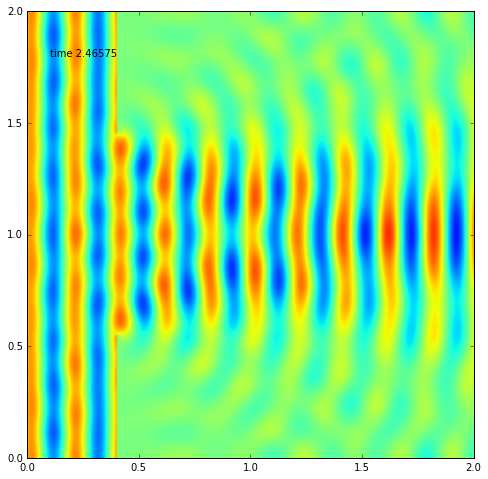

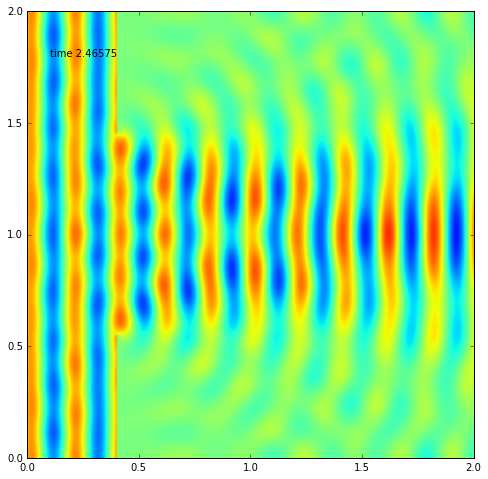

In [79]:
%matplotlib inline
from IPython import display #for continous display
import matplotlib.pyplot as plt #plotting

def plotwave(u,time):
    plt.clf()
    #plot the pressue field
    plt.imshow(u, origin='upper', extent=[0., 2., 0., 2.], vmax=2, vmin=-2) #plot the wave field
    plt.text(0.1,1.8,"time {0:.5f}".format(time)) #annotate the time
    plt.gca().set_xlim([0.,2.])
    plt.gca().set_ylim([0.,2.])
    display.clear_output(wait=True)
    display.display(plt.gcf())

plt.figure(1, figsize=(8, 8), dpi=100)
#setup waveobject
a=WaveSolver(nx=512,CFL=.3,wavelength=0.2,output=300,plotcallback=plotwave,sim_duration=2.5,src_duration=2.5)
#setup an experiment
a.singleslit(ow=0.9,pos=.4)
#a.doubleslit(dw=0.6,ow=0.15,pos=1.)
#start solving it
a.solve()

In [120]:
a.solve()

In [15]:
a=[]
if a: print "hallo"

In [93]:
range?

In [ ]:
CFL

In [18]:
not('k' in vars())

True

In [1]:
stuff = {'west': 'open', 'east': 'reflective'}

In [7]:
stuff['west'] is 'open'

True

In [13]:
import numpy as np
a=np.zeros((10,10))

In [20]:
type(a)==np.ndarray

True

In [4]:
a=[1]
not not a

True

In [27]:
a=1
type(a)

int

In [31]:
range?